### This Jupyter notebook loads a precomputed randomly distributed set of synthetic features (lune_lat, lune_lon) and we run them through each classifier model loaded from saved files.  The models predict class membership and class probabilities.  These values are output to a csv file and loaded by external plotting routine to plot the decision boundaries for comparisons.   


In [17]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, label_binarize
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report

from sklearn.preprocessing import LabelBinarizer
from sklearn.multiclass import OneVsRestClassifier

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

import warnings
from sklearn import set_config
set_config(display="diagram")
warnings.filterwarnings('ignore')
import pickle

In [18]:
#
# load the classifier estimator and do predicts 
# (both class type and individual class probabilities)
# from a list of observed/measured or simulated features
# returns original dataframe with added columns: 
#      columns: class, etype_pred, prob_eq, prob_ex, prob_co 
#
def physics_test_predict( clf, X, class_labels ):
    # np.set_printoptions(precision=3, suppress=True)
    # np.set_printoptions(formatter={'float': '{: 0.2f}'.format})
    #
    nrows = len(X)
    idx = clf.predict(X)
    probs = clf.predict_proba(X)
    
    etype = np.empty(nrows, dtype=object)
    for i in range(nrows):
        etype[i] = class_labels[int(idx[i])]
            
    X['class'] = idx[:]
    X['etype_pred'] = etype[:]
    X['prob_eq'] = probs[:,0]
    X['prob_ex'] = probs[:,1]
    X['prob_co'] = probs[:,2]

    return(X)

### We loaded a sest of 50,005 precomputed lune_lon, and lune_lat features.  These were uniformly distributed on an eigenvalue sphere.  The values were simulate using a C-code.  


In [19]:
df = pd.read_csv( "data/lune2mt.csv")    
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50005 entries, 0 to 50004
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   lune_lon  50005 non-null  float64
 1   lune_lat  50005 non-null  float64
 2   pvr       50005 non-null  float64
 3   pdc       50005 non-null  float64
 4   pclvd     50005 non-null  float64
 5   piso      50005 non-null  float64
 6   Mo        50005 non-null  float64
 7   mxx       50005 non-null  float64
 8   myy       50005 non-null  float64
 9   mzz       50005 non-null  float64
 10  mxy       50005 non-null  float64
 11  mxz       50005 non-null  float64
 12  myz       50005 non-null  float64
 13  eig1      50005 non-null  float64
 14  eig2      50005 non-null  float64
 15  eig3      50005 non-null  float64
dtypes: float64(16)
memory usage: 6.1 MB


### The numbers were randomly generated for a spherical uniform distribution

In [20]:
df[['lune_lat', 'lune_lon', 
    'mxx', 'myy', 'mzz', 'mxy', 'mxz', 'myz', 'eig1', 'eig2', 'eig3']].describe()

,lune_lat,lune_lon,mxx,myy,mzz,mxy,mxz,myz,eig1,eig2,eig3
count,50005.000000,50005.000000,50005.000000,50005.000000,50005.000000,50005.000000,50005.000000,50005.000000,50005.000000,50005.000000,50005.000000
mean,-0.043371,-0.041304,0.000035,0.000343,-0.001908,0.001067,0.001348,-0.000481,-0.589529,-0.001281,0.589281
std,39.080786,17.352403,0.505957,0.503402,0.503210,0.287811,0.287755,0.287633,0.431674,0.435216,0.434523
min,-90.000000,-30.000000,-1.000000,-1.000000,-1.000000,-0.930300,-0.939600,-0.925800,-1.000000,-1.000000,-1.000000
25%,-29.924000,-15.078000,-0.418000,-0.413100,-0.419500,-0.192400,-0.193200,-0.197000,-0.998800,-0.371800,0.299900
50%,0.076000,0.006000,0.000877,0.000398,0.000444,0.001190,-0.001187,0.000598,-0.735100,-0.001690,0.736000
75%,30.061000,14.948000,0.421500,0.415500,0.412400,0.194800,0.196400,0.195000,-0.294300,0.368700,0.999700
max,90.000000,30.000000,1.000000,1.000000,1.000000,0.941900,0.943000,0.922300,1.000000,1.000000,1.000000


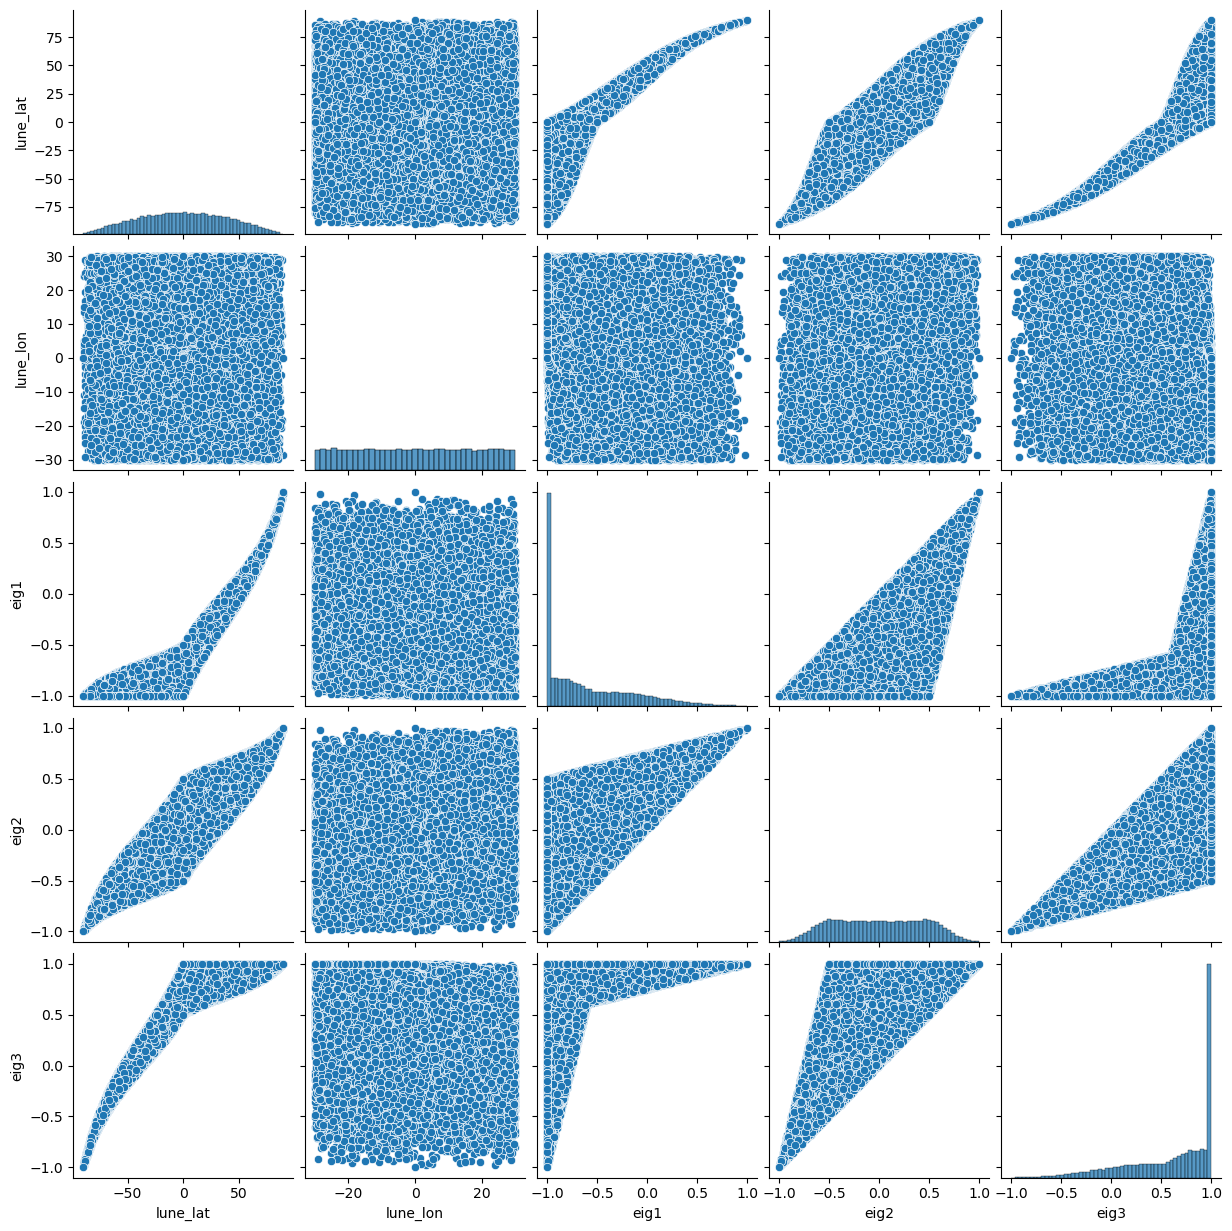

In [21]:
sns.pairplot( data = df[['lune_lat', 'lune_lon', 'eig1', 'eig2', 'eig3']] )

## We are going to append predictions to the original dataframe-X using all the classifiers/estimators and the write them out to be plotted on a sphere to see where the decision lines are placed.

In [22]:
features = ['lune_lat', 'lune_lon']
X_synth = df[features]
class_labels = ['eq', 'ex', 'co']

# Support Vector Classifier

In [48]:
filename = 'output/svc_grid.sav'
load_svc_grid = pickle.load(open(filename, 'rb'))
features = ['lune_lat', 'lune_lon']
X_synth = df[features]
X_new = physics_test_predict( load_svc_grid, X_synth, class_labels )
X_new.to_csv('output/svc.csv', index=False)

![Lune plot for SVC](output/svc.lune.jpg)

# Decision Tree Classifer

In [47]:
filename = 'output/dtc_grid.sav'
load_dtc_grid = pickle.load(open(filename, 'rb'))
features = ['lune_lat', 'lune_lon']
X_synth = df[features]
X_new = physics_test_predict( load_dtc_grid, X_synth, class_labels )
X_new.to_csv('output/dtc.csv', index=False)

![Lune plot for DTC](output/dtc.lune.jpg)

# KnearestneighborsClassifier 

In [46]:
filename = 'output/knn_grid.sav'
load_knn_grid = pickle.load(open(filename, 'rb'))
features = ['lune_lat', 'lune_lon']
X_synth = df[features]
X_new = physics_test_predict( load_knn_grid, X_synth, class_labels )
X_new.to_csv('output/knn.csv', index=False)

![Lune plot for KNN](output/knn.lune.jpg)

# LogisticRegression

In [45]:
filename = 'output/lgr_grid.sav'
load_lgr_grid = pickle.load(open(filename, 'rb'))
features = ['lune_lat', 'lune_lon']
X_synth = df[features]
X_new = physics_test_predict( load_lgr_grid, X_synth, class_labels )
X_new.to_csv('output/lgr.csv', index=False)

![Lune plot for LGR](output/lgr.lune.jpg)

# RandomForestClassifier

In [44]:
filename = 'output/rfc_grid.sav'
load_rfc_grid = pickle.load(open(filename, 'rb'))
features = ['lune_lat', 'lune_lon']
X_synth = df[features]
X_new = physics_test_predict( load_rfc_grid, X_synth, class_labels )
X_new.to_csv('output/rfc.csv', index=False)

![Lune plot for RFC](output/rfc.lune.jpg)

# GausianProcessClassifier

In [37]:
filename = 'output/gpc_grid.sav'
load_gpc_grid = pickle.load(open(filename, 'rb'))
features = ['lune_lat', 'lune_lon']
X_synth = df[features]
X_new = physics_test_predict( load_gpc_grid, X_synth, class_labels )
X_new.to_csv('output/gpc.csv', index=False)

![Lune plot for GPC](output/gpc.lune.jpg)

# Multilayer Perceptron classifier

In [43]:
filename = 'output/mlp_grid.sav'
load_mlp_grid = pickle.load(open(filename, 'rb'))
class_labels = ['eq', 'ex', 'co']
features = ['lune_lat', 'lune_lon']
X_synth = df[features]
X_new = physics_test_predict( load_mlp_grid, X_synth, class_labels )
X_new.to_csv('output/mlp.csv', index=False)

![Lune plot for MLP](output/mlp.lune.jpg)

# AdaBoostClassifier

In [42]:
filename = 'output/abc_grid.sav'
load_abc_grid = pickle.load(open(filename, 'rb'))
features = ['lune_lat', 'lune_lon']
X_synth = df[features]
X_new = physics_test_predict( load_abc_grid, X_synth, class_labels )
X_new.to_csv('output/abc.csv', index=False)  

![Lune plot for ABC](output/abc.lune.jpg)

# GaussianNaiveBayes Classifier

In [34]:
filename = 'output/gnb_grid.sav'
load_gnb_grid = pickle.load(open(filename, 'rb'))
features = ['lune_lat', 'lune_lon']
X_synth = df[features]
X_new = physics_test_predict( load_gnb_grid, X_synth, class_labels )
X_new.to_csv('output/gnb.csv', index=False)

![Lune plot for GNB](output/gnb.lune.jpg)

# QuadraticDiscriminantAnalysis

In [35]:
filename = 'output/qda_grid.sav'
load_qda_grid = pickle.load(open(filename, 'rb'))
features = ['lune_lat', 'lune_lon']
X_synth = df[features]
X_new = physics_test_predict( load_qda_grid, X_synth, class_labels )
X_new.to_csv('output/qda.csv', index=False)

![Lune plot for QDA](output/qda.lune.jpg)

![Lune plot for ANN](output/nn.mt.jpg)

![Lune plot for ANN](output/nn.lune.lune.jpg)